<a href="https://colab.research.google.com/github/tarannummuzaffar/super/blob/main/Kolmogorov_Arnold_critique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kolmogorov-Arnold Networks: A Critique

Kolmogorov-Arnold Networks (KANs) are an innovation in the field of deep learning, offering a new way to construct neural networks inspired by the existing Kolmogorov-Arnold representation theorem. They present themselves as a potential alternative to the widely used Multi-Layer Perceptrons (MLPs) that power many deep learning applications.

While MLPs have fixed activation functions on nodes ("neurons"), KANs have learnable activation functions on edges ("weights"). KANs have no linear weights at all - every weight parameter is replaced by a univariate function parametrized as a spline, which allows switching between coarse-grained and fine-grained grids.

![](https://drive.google.com/uc?export=view&id=1vD84fyLkIYBqXq3dPXaDSRGOs9_Q9rgT)

While MLPs rely on fixed activation functions (like ReLU or sigmoid) applied at each neuron within a hidden layer, KANs take a different approach. They place the emphasis on the connections (edges) between neurons. Here's how they differ:

* MLPs: Activation functions in MLPs are pre-defined and non-linear. They introduce the essential ability for the network to learn complex relationships between input data and the desired output. The connections between neurons carry simple weights that are adjusted during training.

* KANs: Instead of using fixed activation functions at each neuron, KANs employ learnable activation functions on the edges themselves. These activation functions are constructed using basis functions, like B-splines. Imagine basis functions as building blocks that can be combined to create more intricate functions. By learning the coefficients of these basis functions, KANs can achieve highly flexible and expressive activation functions on each connection. Notably, KANs completely remove traditional linear weights from the network, with all weight parameters being replaced by the coefficients within the edge's activation function.

#Potential Benefits of KANs
* Enhanced Accuracy: The learnable activation functions in KANs have the potential to capture more complex relationships in the data compared to the fixed activations of MLPs. This flexibility can lead to superior performance on specific tasks, especially those involving intricate patterns.
* Improved Interpretability: Unlike the somewhat opaque nature of MLPs (black box), KANs offer a degree of interpretability. By analyzing the learned coefficients of the basis functions, researchers can gain insights into how the network makes decisions. This can be valuable for understanding the inner workings of the model and potentially improving its performance further.

#Challenges and Considerations
* Increased Training Time: The process of learning the coefficients for the basis functions within the activation functions can be computationally expensive. This translates to longer training times for KANs compared to MLPs, especially for complex network architectures.
* Hyperparameter Tuning: KANs introduce new hyperparameters related to the selection and number of basis functions used. Finding the optimal configuration for these hyperparameters requires more effort compared to tuning the simpler MLP architecture.
* KANs overfit to everything: In this experiment, KANs fitted the pure random data in the features to the labels provided.

LET'S CODE!

In [ ]:
! pip install pykan==0.0.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
%cd /content/drive/My Drive/Colab_Notebooks/

/content/drive/My Drive/Colab_Notebooks


##Dataset

The dataset I used can be found on Kaggle, and relates to credit card fraud:

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [ ]:
from kan import KAN
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from scipy import stats

df=pd.read_csv('creditcard.csv').reset_index()
df=df.iloc[:,1:]
df.shape

(284807, 31)

In [ ]:
df=df.dropna().sample(frac=1)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
86393,61214.0,-0.940821,-0.195243,1.829045,1.280440,1.060675,-0.336654,0.023740,0.148624,-0.205576,...,0.069084,0.241810,-0.038508,0.201583,-0.159875,-0.330642,-0.037104,-0.084373,1.00,0
27917,34767.0,1.181405,0.209867,0.243716,1.150893,-0.364365,-0.970321,0.212759,-0.200700,0.087767,...,0.038601,0.049913,-0.119582,0.374424,0.652078,-0.329156,0.002908,0.024429,36.84,0
189784,128558.0,-1.110969,1.794650,-1.245472,-0.581940,0.385056,-0.671445,0.173517,-0.272194,0.068754,...,0.439718,-1.084242,0.306519,0.486279,-0.340317,0.093927,-0.170701,-0.207810,8.99,0
47644,43291.0,-0.769805,0.232534,0.408205,-0.532804,2.910801,3.258692,-0.325644,0.953521,-0.872402,...,-0.209514,-0.945916,-0.080907,1.000862,0.175697,0.290841,0.020483,0.080084,0.99,0
32308,36739.0,1.166149,-0.456493,0.952648,0.713149,-0.570814,1.133179,-0.841094,0.374439,1.288751,...,-0.332013,-0.517608,-0.143213,-0.761201,0.488126,0.458869,0.023514,0.003128,19.95,0


#Variable Selection

For variable selection I used a simple t-Test, a statistical test used to compare the means of two groups to determine if they are significantly different from each other. It can be used to assess whether the means of the continuous variable differ between the categories defined by the categorical variable.

In [ ]:
# t-test
selected=[]
for i in range(1,df.shape[1]-1):
    t_stat, p_value = stats.ttest_ind(df[df.Class==0].iloc[:,i], df[df.Class==1].iloc[:,i])
    print(t_stat)
    if p_value<0.01 and abs(t_stat)>120:
        selected.append(i)
selected

54.366064281917595
-48.92240466693359
104.95002765789474
-71.8598087549023
50.91520331663207
23.313313312405917
101.73301041335796
-10.608877735555248
52.408017261455434
118.56635266832792
-83.6621482325888
144.0479863147297
2.438785015518105
169.39760266328938
2.253928457259566
106.97359219787425
184.33439340877757
59.86969688477179
-18.573933257057682
-10.723792762273225
-21.585093267027247
-0.4297749367405662
1.4329955786067727
3.853690762328184
-1.7652370278903353
-2.3777411407862217
-9.38324551012865
-5.089342256000726
-3.005552313971414


[12, 14, 17]

# Data Preparation

In [ ]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming df and selected are predefined
X_train, X_test, y_train, y_test = train_test_split(np.array(df.iloc[:10000, selected]), np.array(df.Class.iloc[:10000]), test_size=0.2, random_state=42, shuffle=True)

# Move the tensors to the specified device
dataset = {}
dataset['train_input'] = torch.from_numpy(X_train).to(torch.float32)
dataset['test_input'] = torch.from_numpy(X_test).to(torch.float32)
dataset['train_label'] = torch.from_numpy(y_train).to(torch.long)
dataset['test_label'] = torch.from_numpy(y_test).to(torch.long)

# Access the tensors
X = dataset['train_input']
y = dataset['train_label']

print(dataset)

{'train_input': tensor([[ 0.8548,  1.2588,  0.4346],
        [-1.9326,  0.9051,  0.5592],
        [ 0.9726,  0.2449, -0.6879],
        ...,
        [-0.2573,  0.8282,  0.2969],
        [-0.0534,  0.4188, -0.5523],
        [-2.8394,  1.1762,  0.2498]]), 'test_input': tensor([[ 0.0754, -0.5809, -1.1609],
        [ 0.6628, -1.4010,  0.8328],
        [-2.3519,  0.2998, -0.0251],
        ...,
        [ 0.6593,  0.2340, -0.3240],
        [ 0.3718,  0.0808, -0.0226],
        [-0.2980, -0.9066, -0.2163]]), 'train_label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'test_label': tensor([0, 0, 0,  ..., 0, 0, 0])}


#Model Architecture

KAN(width=[first hidden, second hidden], grid=depth of grid, k=piecewise polynomial)

In [ ]:
model = KAN(width=[3,3], grid=3, k=3) # hidden, input
model

KAN(
  (biases): ModuleList(
    (0): Linear(in_features=3, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0): KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0): Symbolic_KANLayer()
  )
)

In [ ]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [ ]:
results = model.train(dataset, opt="Adam", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

train loss: 3.56e-01 | test loss: 2.46e-01 | reg: 9.55e+00 : 100%|██| 20/20 [00:01<00:00, 11.56it/s]


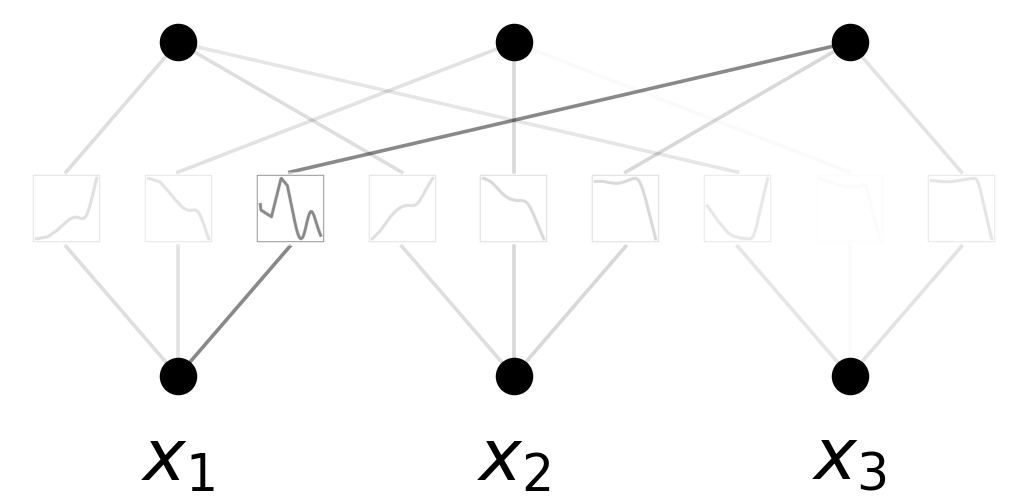

In [ ]:
model.plot(beta=0.2,scale=1.3,in_vars=[r'$x_{}$'.format(i) for i in range(1,4)])

#Function Activations (Splines)

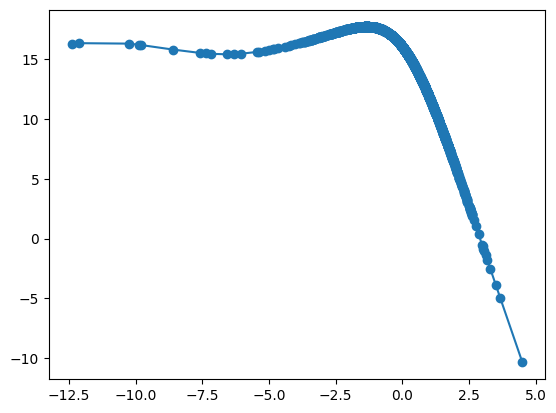

In [ ]:
l = 0
i = 1
j = 2

inputs = model.spline_preacts[l][:,j,i]
outputs = model.spline_postacts[l][:,j,i]
rank = np.argsort(inputs)
inputs = inputs[rank]
outputs = outputs[rank]
plt.plot(inputs, outputs, marker="o")

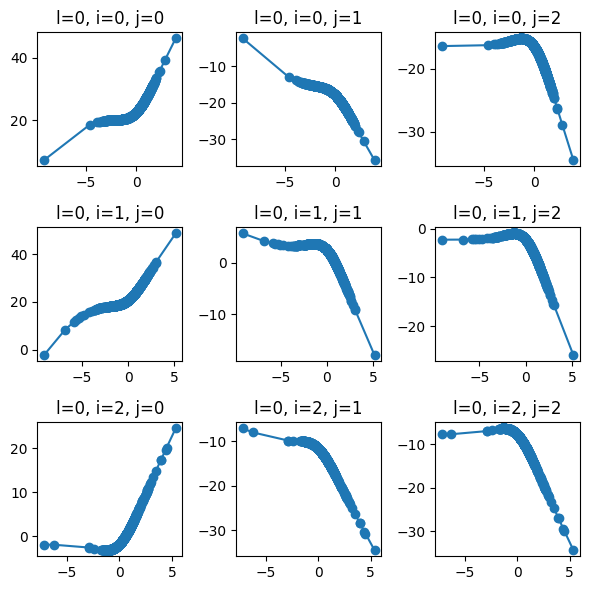

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is predefined and contains 'spline_preacts' and 'spline_postacts'

# Create a figure and a grid of subplots
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
l=0
# Iterate over all combinations of l, i, j
for i in range(3):
    for j in range(3):
        # Get the appropriate subplot
        inputs = model.spline_preacts[l][:, j, i]
        outputs = model.spline_postacts[l][:, j, i]
        rank = np.argsort(inputs)
        inputs = inputs[rank]
        outputs = outputs[rank]

        # Plot on the appropriate subplot
        ax[i, j].plot(inputs, outputs, marker="o")
        ax[i, j].set_title(f'l={l}, i={i}, j={j}')

# Adjust layout
plt.tight_layout()
plt.show()


#Model Pruning

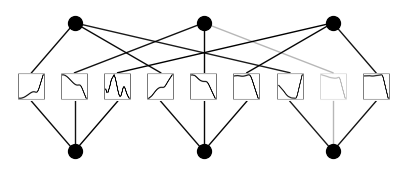

In [ ]:
model = model.prune()
model(dataset['train_input'])
model.plot()
#### THEN, RETRAIN

In [ ]:
results = model.train(dataset, opt="Adam", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

train loss: 4.98e-01 | test loss: 4.82e-01 | reg: 1.95e+01 : 100%|██| 20/20 [00:04<00:00,  4.55it/s]


In [ ]:
results['train_acc'][-1], results['test_acc'][-1]

(0.9984583258628845, 0.9984999895095825)

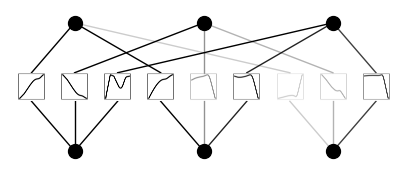

In [ ]:
model.plot()

r2 is 0.8676734566688538
r2 is not very high, please double check if you are choosing the correct symbolic function.


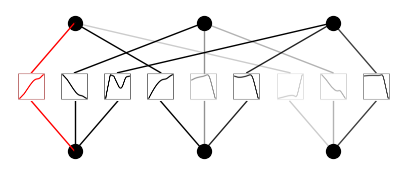

In [ ]:
model.fix_symbolic(0,0,0,'sin') # Symbolification
model.plot(beta=3)

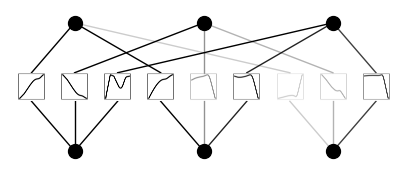

In [ ]:
model.unfix_symbolic(0,0,0)
model.plot(beta=3)


In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs'] #  3 variables + BIAS -- (input, variable/activat B-spline in layer 1, variable/activat B-spline in layer 2)
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]

fixing (0,0,0) with x^3, r2=0.9147007465362549
fixing (0,0,1) with tanh, r2=0.953362226486206
fixing (0,0,2) with sin, r2=0.9926820993423462
fixing (0,1,0) with log, r2=0.913926362991333
fixing (0,1,1) with tanh, r2=0.9845781922340393
fixing (0,1,2) with tanh, r2=0.9886985421180725
fixing (0,2,0) with tanh, r2=0.9897085428237915
fixing (0,2,1) with x^3, r2=0.884966254234314
fixing (0,2,2) with tanh, r2=0.991733729839325


In [ ]:
formula1, formula2,formula3 = model.symbolic_formula()[0] ## BIAS INCLUDED
formula1

-3.7*(-0.28*x_1 - 1)**3 + 53.05*log(0.6*x_2 + 7.93) + 22.11*tanh(0.46*x_3 - 1.18) + 52.58

In the original article, the formulas (or equations) of each B-spline are in order to ensure the correct representation and approximation of the function f. The B-spline basis functions are defined over specific intervals, and their support (the region where they are non-zero) is limited. Therefore, arranging the B-spline equations in order ensures that the function f is accurately reconstructed over its entire domain by summing up these basis functions in a linear combination.

Additionally, this ordered structure is crucial for the approximation bounds. The theorem relies on the ordered application of the B-spline functions to provide a bound on the approximation error in terms of the grid size G. This ordered application maintains the continuity and differentiability properties required for the approximation to hold.

By following this order, we can systematically refine the grid (from coarse to fine) while maintaining the accuracy and stability of the approximation process. This approach is fundamental for ensuring that the approximation error decreases as the grid becomes finer, which is a key aspect of the spline-based approximation theory.

In [ ]:
def acc(formula1, formula2,formula3, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
        logit3 = np.array(formula3.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
        correct += (logit3 > logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2,formula3, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2,formula3, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9984)
test acc of the formula: tensor(0.9985)


In [ ]:
logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
logit3 = np.array(formula3.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
(logit1>logit2>logit3)

False

In [ ]:
(logit1>logit2>logit3).astype(float)

0.0

**However**, if we define:

df.V12=np.random.random(df.shape[0])

df.V14=np.random.random(df.shape[0])

df.V17=np.random.random(df.shape[0])

... the model will still get a 0.99 accuracy

**Explanation**:

Note that the accuracy is indeed extremely high, in both train and test sets. In fact KANs have the capability to fit any continuous function including random data, in a mechanism similar to adding uncorrelated variables to MLPs to increase accuracy. It is said that with proper regularisation, degree of smoothness of the B-spline and depth of the network, the chances of finding the optimal fitting are higher with KAN than MLP. But this statement needs empirical support.

#REFERENCES

KAN: Kolmogorov–Arnold Networks. Ziming Liu, Yixuan Wang, Sachin Vaidya, Fabian Ruehle, James Halverson, Marin Soljacic, Thomas Y. Hou, Max Tegmark, 2024 https://arxiv.org/pdf/2404.19756